In [7]:
import torch
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

#use gpu number 3 
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

file_id=6448
#file_id=23114

base_path="/home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/"
file_dry=os.path.join(base_path, "dry",str(file_id),"vocals.wav")
file_wet=os.path.join(base_path, "wet",str(file_id),"vocals.wav")

file_dry_fxnorm=os.path.join(base_path,"dry", str(file_id), "vocals_normalized.wav")
file_wet_fxnorm=os.path.join(base_path, "wet",str(file_id), "vocals_normalized.wav")

file_dry_fxnorm_dr=os.path.join(base_path, "dry", str(file_id), "vocals_normalized_dr.wav")
file_wet_fxnorm_dr=os.path.join(base_path, "wet",str(file_id),"vocals_normalized_dr.wav")

import soundfile as sf

print("Loading files:", file_dry, file_wet)
dry, sr = sf.read(file_dry)
print("Loading files:", file_dry, file_wet)
wet, sr = sf.read(file_wet)
print("files loaded")

#file_dry_fxnorm, sr=sf.read(file_dry_fxnorm_dr)
#file_wet_fxnorm, sr=sf.read(file_wet_fxnorm_dr)

dry=torch.from_numpy(dry.T).float().unsqueeze(0)
wet=torch.from_numpy(wet.T).float().unsqueeze(0)

#dry_fxnorm=torch.from_numpy(file_dry_fxnorm.T).float().unsqueeze(0)

dry=dry.mean(dim=1, keepdim=True)

#dry_fxnorm=torch.from_numpy(file_dry_fxnorm.T).float().unsqueeze(0)


start_t=15*sr
segment_length = 524288
wet_segment = wet[...,start_t:start_t + segment_length]


import pyloudnorm as pyln
meter = pyln.Meter(sr)
normaliser = lambda x: pyln.normalize.loudness(
    x, meter.integrated_loudness(x), -18.0
)

print("dry", dry.shape, dry.min(), dry.max())

dry = torch.from_numpy(normaliser(dry.numpy().T).T).float().to(device)
#wet = torch.from_numpy(normaliser(wet.numpy().T).T).float().to(device)
#dry_fxnorm = torch.from_numpy(normaliser(dry_fxnorm.numpy().T).T).float().to(device)


print("dry", dry.shape,dry.min(), dry.max())
dry_segment = dry[...,start_t:start_t + segment_length]


from IPython.display import Audio

Audio(dry_segment[0].cpu().numpy(), rate=sr, normalize=False)
#Audio(wet_segment[0].cpu().numpy(), rate=sr, normalize=True)



Using device: cuda
Loading files: /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/dry/6448/vocals.wav /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/wet/6448/vocals.wav
Loading files: /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/dry/6448/vocals.wav /home/eloi/projects/project_mfm_eloi/audio_examples/TM_val/wet/6448/vocals.wav
files loaded
dry torch.Size([1, 1, 11065479]) tensor(-0.1188) tensor(0.1767)
dry torch.Size([1, 1, 11065479]) tensor(-0.7274, device='cuda:0') tensor(1.0821, device='cuda:0')


/home/eloi/myenv/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


In [8]:
from fx_model.distribution_presets.clusters_vocals import get_distributions_Cluster0, get_distributions_Cluster1 

from fx_model.fx_pipeline import EffectRandomizer
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

distributions_dict=get_distributions_Cluster0(sample_rate=44100)

effect_randomizer=EffectRandomizer(sample_rate=44100, distributions_dict=distributions_dict, device=device)

num_examples=512
batch_size=32

inputs = dry_segment.repeat(batch_size, 1, 1).to(device)

outputs_C0 = {}

for i in range(0, num_examples, batch_size):
    res=effect_randomizer.forward(inputs)
    res_list= res.cpu().unbind(dim=0)
    for j, output in enumerate(res_list):
        outputs_C0[i*batch_size + j] = output


distributions_dict=get_distributions_Cluster1(sample_rate=44100)
effect_randomizer=EffectRandomizer(sample_rate=44100, distributions_dict=distributions_dict, device=device)

outputs_C1 = {}

for i in range(0, num_examples, batch_size):
    res=effect_randomizer.forward(inputs)
    res_list= res.cpu().unbind(dim=0)
    for j, output in enumerate(res_list):
        outputs_C1[i*batch_size + j] = output




Computing KAD distance...


/home/eloi/projects/project_mfm_eloi/src/evaluation/dist_metrics.py:428: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y=torch.tensor(y).permute(1,0).unsqueeze(0).to(self.device)
/home/eloi/projects/project_mfm_eloi/src/evaluation/dist_metrics.py:429: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_hat=torch.tensor(y_hat).permute(1,0).unsqueeze(0).to(self.device)


y_values shape: torch.Size([203, 512])
Calculating bandwidth...
y shape: torch.Size([203, 512])
Bandwidth: 0.9075080156326294


/home/eloi/projects/project_mfm_eloi/src/evaluation/dist_metrics.py:101: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32)


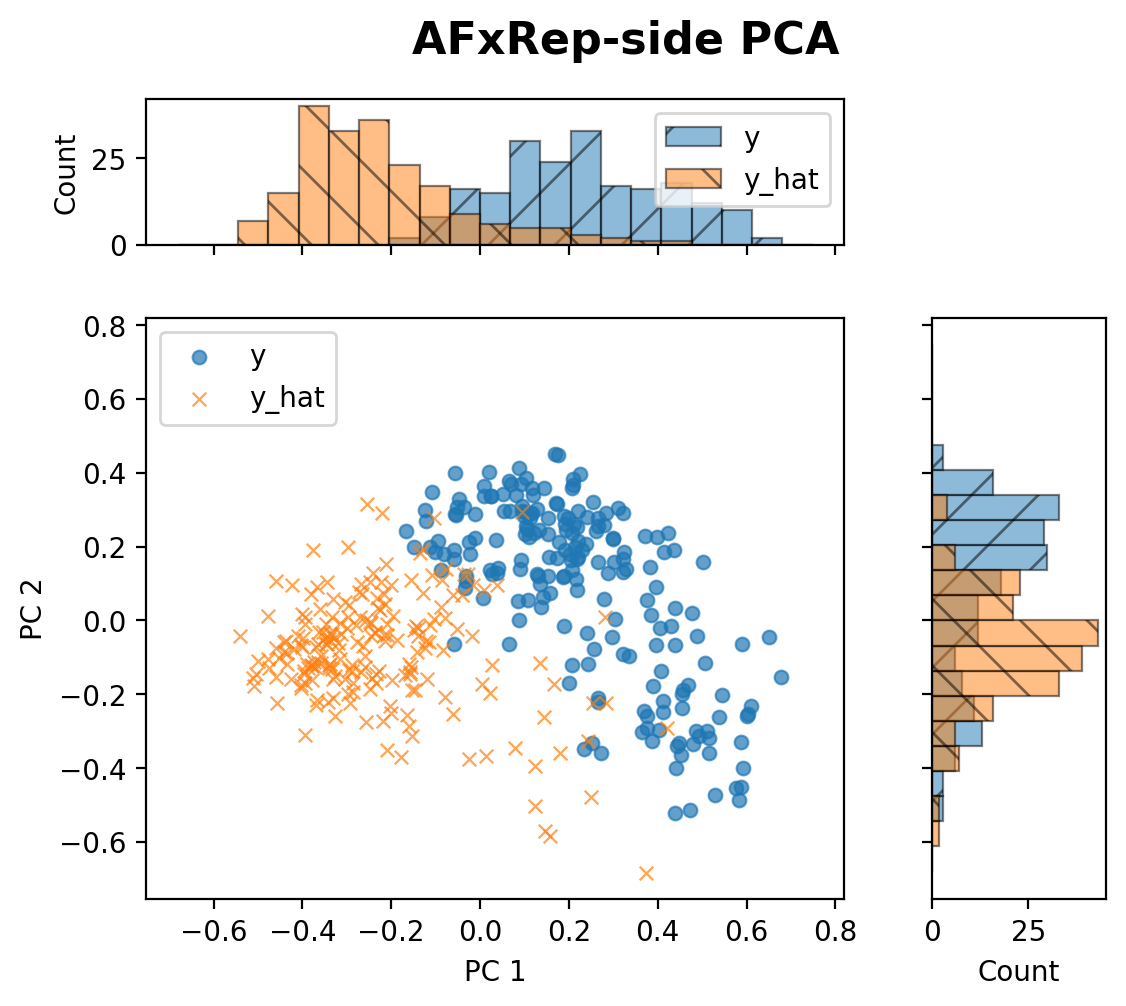

: 

In [ ]:
from evaluation.dist_metrics import KADFeatures 
import omegaconf
fx_encoder_args= omegaconf.OmegaConf.create(
    {
        "distance_type": "cosine",
        "ckpt_path": "/home/eloi/projects/project_mfm_eloi/src/utils/feature_extractors/ckpt/fxenc_default.pt",
        "config_file": "/home/eloi/projects/project_mfm_eloi/src/utils/feature_extractors/networks/configs.yaml"
    })

AFxRep_args= omegaconf.OmegaConf.create(
    {
        "distance_type": "cosine", #distance metric to use for the AFxRep
        "ckpt_path": "/home/eloi/projects/project_mfm_eloi/src/tmp/afx-rep.ckpt"
    }
)

fx_encoder_plusplus_args= omegaconf.OmegaConf.create(
    {
        "distance_type": "cosine",
        "ckpt_path": "/home/eloi/projects/project_mfm_eloi/src/utils/feature_extractors/ckpt/fxenc_plusplus_default.pt",
    })

KAD_args = omegaconf.OmegaConf.create(
    {
  "do_PCA_figure": True, #if True, the FAD figure will be compute
  "PCA_fit_mode": "all",
  "kernel": "gaussian" #kernel to use for the KAD metric
    }
)


metric = KADFeatures(sample_rate=44100, AFxRep_args=AFxRep_args, fx_encoder_args=fx_encoder_args, type="AFxRep-side", KAD_args=KAD_args, fx_encoder_plusplus_args=fx_encoder_plusplus_args, device=device)
out_1, out_2= metric.compute(outputs_C0, outputs_C1, None)

In [10]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from datasets.tency_mastering_simulated import TencyMastering_Test
import omegaconf
normalize_params=omegaconf.OmegaConf.create(
    {
    "normalize_mode": "loudness_dry",
    "loudness_dry": -18.0
    }
)

dataset_val_C0= TencyMastering_Test(
  mode= "dry-wet",
  segment_length= 525312,
  fs= 44100,
  stereo= True,
  tracks= ["vocals"],
  clusters= [0],
  path_csv= "/data5/eloi/TencyMastering/CLAP_emb_selected/val_split.csv",
  normalize_params=normalize_params,
  num_examples= -1, #use all examples
  x_as_mono= True,
  RMS_threshold_dB= -40.0,
  seed= 42
)

dataset_val_C1= TencyMastering_Test(
  mode= "dry-wet",
  segment_length= 525312,
  fs= 44100,
  stereo= True,
  tracks= ["vocals"],
  clusters= [1],
  path_csv= "/data5/eloi/TencyMastering/CLAP_emb_selected/val_split.csv",
  normalize_params=normalize_params,
  num_examples= -1, #use all examples
  x_as_mono= True,
  RMS_threshold_dB= -40.0,
  seed= 42
)



-1 num_examples
mode dry-wet


3it [00:08,  3.01s/it]/home/eloi/myenv/lib/python3.11/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
21it [01:18,  3.74s/it]


test_samples 203 num_examples -1
-1 num_examples
mode dry-wet


21it [01:22,  3.94s/it]

test_samples 273 num_examples -1


In [11]:

import torch
batch_size=32
val_loader_C0 = torch.utils.data.DataLoader(dataset=dataset_val_C0, batch_size=batch_size, num_workers=1)
val_loader_C1 = torch.utils.data.DataLoader(dataset=dataset_val_C1, batch_size=batch_size, num_workers=1)   


from fx_model.distribution_presets.clusters_vocals import get_distributions_Cluster0, get_distributions_Cluster1 

from fx_model.fx_pipeline import EffectRandomizer
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

distributions_dict=get_distributions_Cluster0(sample_rate=44100)

effect_randomizer=EffectRandomizer(sample_rate=44100, distributions_dict=distributions_dict, device=device)



outputs_C0 = {}
for i,( x, cluster) in enumerate(val_loader_C0):
    #stereo to mono
    x= x.mean(dim=1, keepdim=True).to(device)
    res=effect_randomizer.forward(x)
    res_list= res.cpu().unbind(dim=0)
    for j, output in enumerate(res_list):
            outputs_C0[i*batch_size + j] = output
    i += 1


distributions_dict=get_distributions_Cluster1(sample_rate=44100)
effect_randomizer=EffectRandomizer(sample_rate=44100, distributions_dict=distributions_dict, device=device)

outputs_C1 = {}

for i, (x, cluster) in enumerate(val_loader_C1):
    x= x.mean(dim=1, keepdim=True).to(device)
    res=effect_randomizer.forward(x)
    res_list= res.cpu().unbind(dim=0)
    for j, output in enumerate(res_list):
            outputs_C1[i*batch_size + j] = output





/home/eloi/myenv/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 11 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/home/eloi/myenv/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 17 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [17]:
from IPython.display import Audio

Audio(outputs_C1[4].cpu().numpy(), rate=sr, normalize=True)